From [EDA & Ensemble Model (Top 10 Percentile)](https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile/notebook)

In [2]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

### Lets Read In The Dataset

In [4]:
dailyData = pd.read_csv("./bike-sharing-demand/train.csv")

### Shape Of The Dataset

In [5]:
dailyData.shape

(10886, 12)

### Sample Of First Few Rows

In [6]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


### Variables Data Type

In [7]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Feature Engineering

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

- Create new columns "date,"hour","weekDay","month" from "datetime" column.
- Coerce the datatype of "season","holiday","workingday" and weather to category.
- Drop the datetime column as we already extracted useful features from it.

### Creating New Columns From "Datetime" Column

In [9]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

### Coercing To Category Type

In [10]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

### Dropping Unncessary Columns

In [11]:
dailyData  = dailyData.drop(["datetime"],axis=1)

### Lets Start With Very Simple Visualization Of Variables DataType Count

TypeError: data type not understood

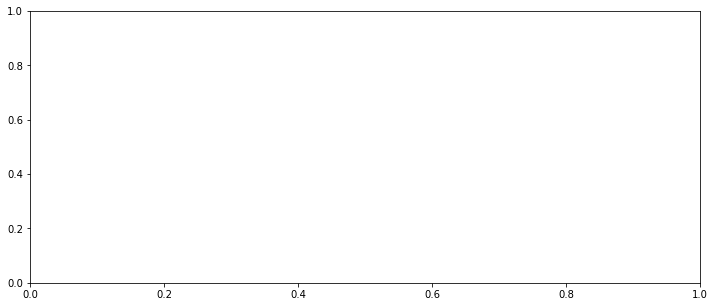

In [12]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

### Missing Values Analysis

Once we get hang of the data and columns, next step we geneally is to find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno".

Its a quiet handy library to quickly visualize variables for missing values. As I mentioned earlier we got lucky this time as there no missing value in the dataset.

### Skewness In Distribution

<AxesSubplot:>

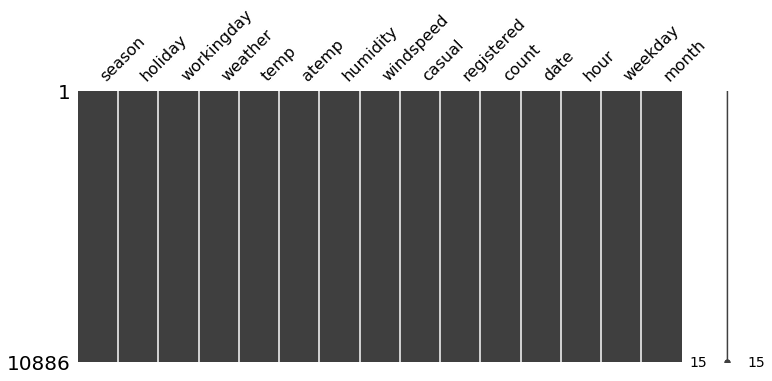

In [14]:
msno.matrix(dailyData,figsize=(12,5))

### Outliers Analysis

At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

- Spring season has got relatively lower count.The dip in median value in boxplot gives evidence for it.
- The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.
- Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

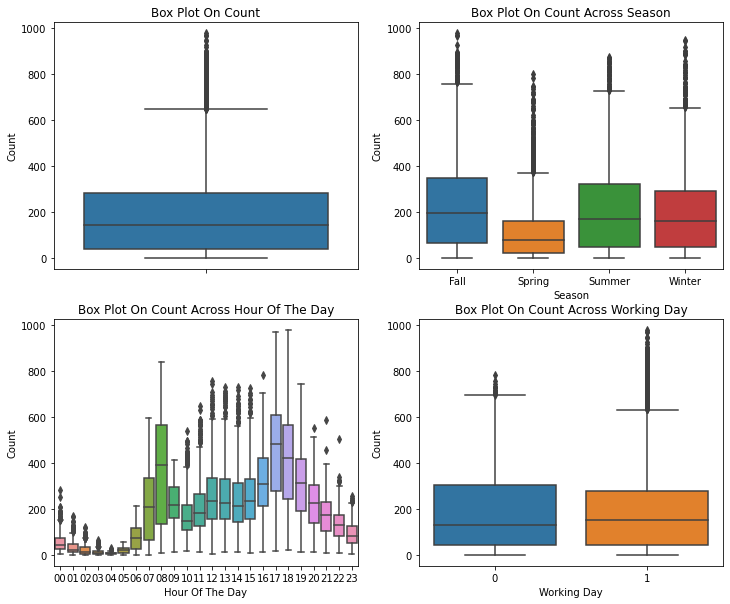

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

### Lets Remove Outliers In The Count Column

In [16]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [17]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


### Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

- temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".
- windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
- "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
- "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

<AxesSubplot:>

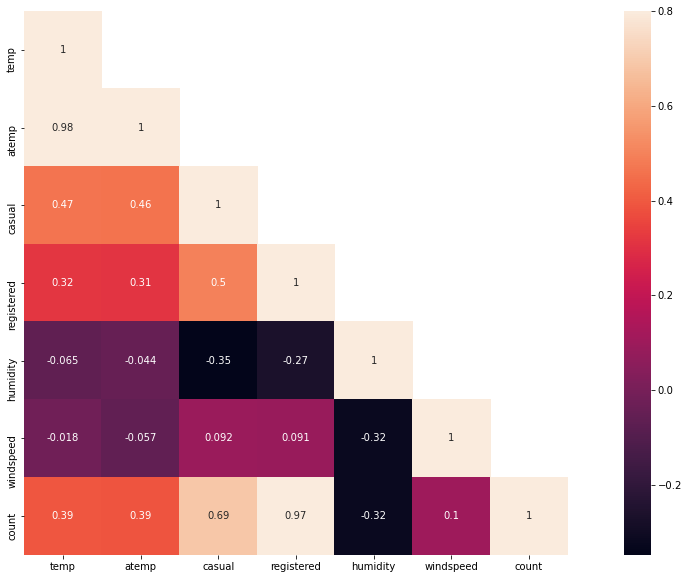

In [18]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

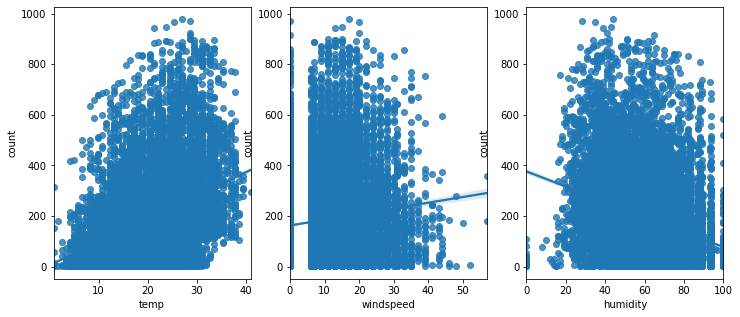

In [19]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

### Visualizing Distribution Of Data

As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

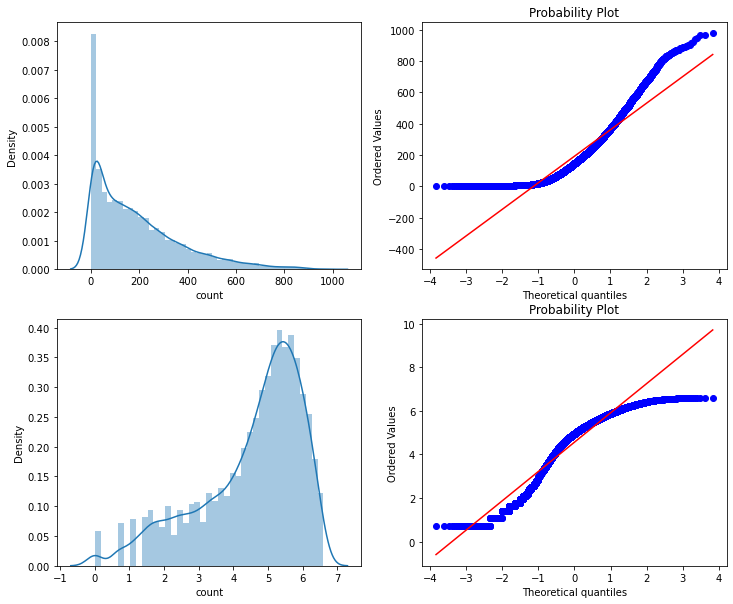

In [21]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

### Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

- It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
- On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
- Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
- The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

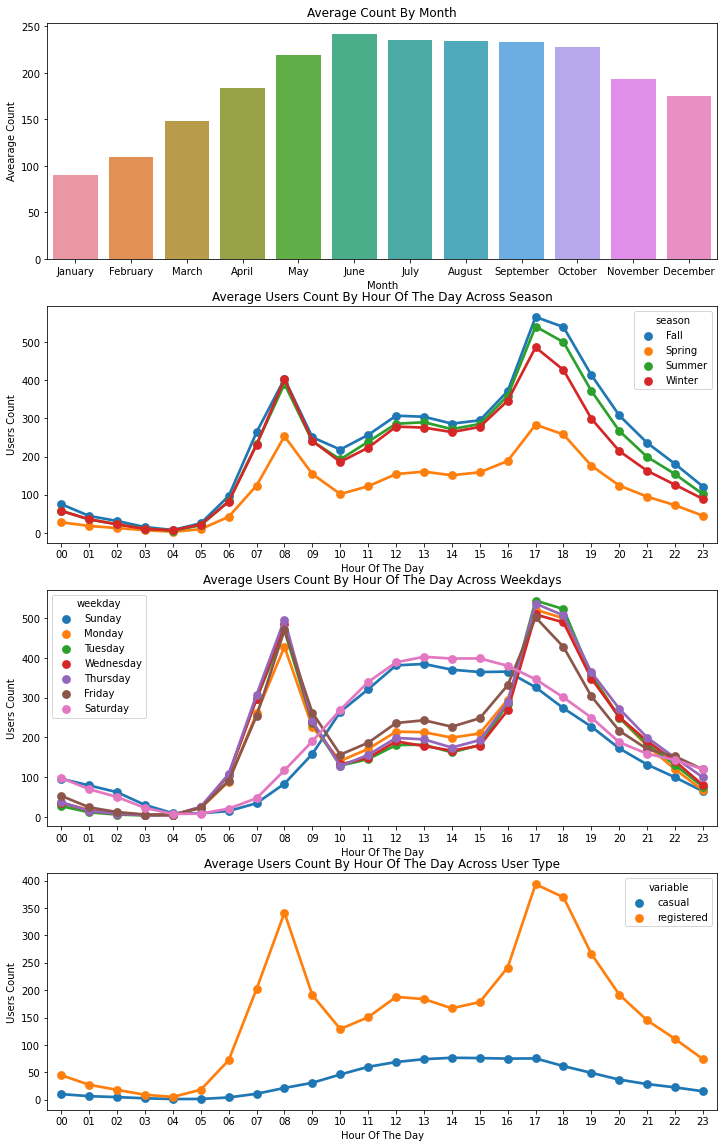

In [23]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

So we have visualized the data to a greater extent.So lets go and build some models and see how close we can predict the results.

### Filling 0's In windspeed Using Random Forest¶

Lets Read In Train And Test Data

In [25]:
dataTrain = pd.read_csv("./bike-sharing-demand/train.csv")
dataTest = pd.read_csv("./bike-sharing-demand/test.csv")

### Combine Train And Test

In [26]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

### Feature Engineering

In [28]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

### Random Forest Model To Predict 0's In Windspeed

In [29]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

### Coercing To Categorical Type

In [31]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [32]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

### Splitting Train And Test Data

In [34]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

### Dropping Unncessary Variables

In [35]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

### RMSLE Scorer

In [36]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Linear Regression Model

In [38]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.9779728543334252


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


### Regularization Model - Ridge

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779728392749344


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

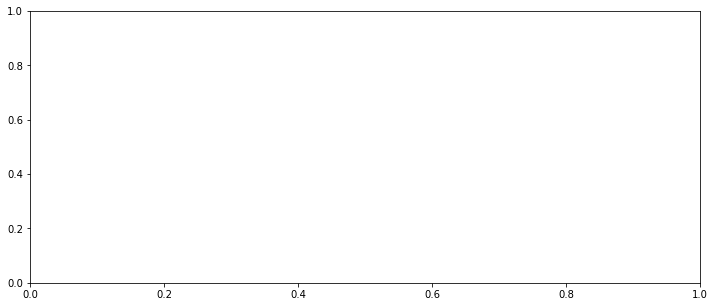

In [39]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### Regularization Model - Lasso

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9781097696271647


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

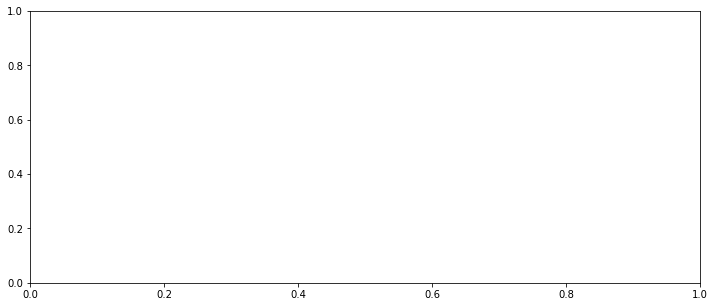

In [40]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### Ensemble Models - Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.102639769905989


### Ensemble Model - Gradient Boost

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.18996461691588815


Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

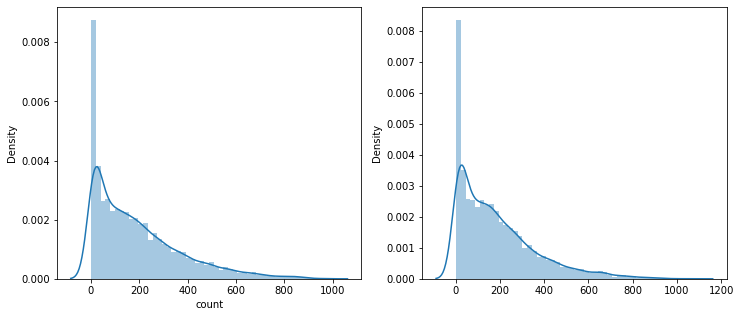

In [44]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [45]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)

### The submission will have test score of 0.41